In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr

from datetime import date
import os
from scipy.io import loadmat
# load preset parameter values
from forecast_conf import (model_directory,xc,yc,range_pix,t_hor,t_ex,I_range,T1,T2)
# import functions
from helper_functions import standardize_dims

In [2]:
# set parameters, if different than in forecast_conf

# location of data
xc=271.5
yc=28.19

# size of image to consider, in +/- from data location, in number of pixels
range_pix=25

# which lead time to train on
t_hor=30

# how many extra data points to take on either side of the desired lead time, in order to increase data points
# note that forecasts are issued every week, so shouldn't use more 6 days before/after
t_ex = 2

# number of forecasts tested per batch, we take two batches
I_range=3

# first forecasts of each batch
T1=27
T2=35

# stack together in array
I_test=np.array([range(T1,T1+I_range),range(T2,T2+I_range)])
I_test = I_test.astype(int)

In [3]:
# load measurements from mat file
# C is current speed
# T is time
C = loadmat('TH_current_ADCP.mat')['C'].squeeze()
T = loadmat('TH_current_ADCP.mat')['T'].squeeze()

In [4]:
import datetime
# convert matlab times to datetime
pdate=pd.to_datetime(T-719529,unit='d').round('s').values


In [5]:
# put current measurements into an xarray for ease of use and re-time to daily mean
meas = xr.Dataset({"Speed": (["time"], C)},coords={"time": pdate})
# retime to 2h means
meas=meas.resample(time="2H").mean()


/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
''''''''''
Now, get a list of directories with forecast data.

The data structured such that each forecast is in one directory, 
and within each directory there is a netcdf file for each lead time, a week apart (usually 46 files)

'''''''''
ls=[x[0] for x in os.walk('.')]
ls_dir=[]
for st in ls:
    # forecast folders are labelled by date, so have "20" in the name
    if st.find('20') > 0:
        ls_dir.append(st)

In [7]:
# make a list of all forecast files across all directories
f_list=[]
f_dir=[]
for y in ls_dir:
    temp=[x[2] for x in os.walk(y)]
    for m in temp[0]:
        if m.find('.nc') > 0:
            f_list.append(y+'/'+m)     
            
# sort the list of all files            
f_list.sort()

# count total number of forecast used
n_f=len(ls_dir)



In [8]:
from datetime import datetime, timedelta


# create arrays to hold X and Y values for CNN
# dimensions are:
# Dims: (forecast, lead times within within forecast, number of ensemble members, x-pixels, y-pixels, number of fields)
X_data=np.empty((n_f,1+2*t_ex,32,2*range_pix,2*range_pix,4))

# Dims: (forecast, lead times within within forecast, number of ensemble members)
Y_data=np.empty((n_f,1+2*t_ex,32))


# parameters used for indexing
dirx=0
dayx=0
dir_p=f_list[0][2:10]


# get indices for (x,y) measurement location
arr=xr.open_dataset(f_list[0])
arr=standardize_dims(arr)
lat=abs(arr.lat-yc)
lon=abs(arr.lon-xc)
yc_i=np.argmin(lat).values
xc_i=np.argmin(lon).values

In [9]:
# load the data in the correct format
for k in f_list:
    # check if moving to new forecast, and update dir_p if so
    if k[2:10] != dir_p:
        dirx+=1
        dir_p=k[2:10]
        
    # calculate forecast lead time, in days
    # date of issue
    date1 = datetime.strptime(k[24:32], '%Y%m%d')
    # date of prediction
    date2 = datetime.strptime(k[33:41], '%Y%m%d')
    # lead time
    dys=(date2-date1).days
    
    # only save data if it is used for training, which is defined by main lead time, and +/- chosen days
    if dys<=(t_hor+t_ex) and dys>=(t_hor-t_ex):
    
        arr=xr.open_dataset(k)
        arr=standardize_dims(arr)
        # load sea surface temperature
        t=arr.water_temp_mb.squeeze()
        # load current speed
        s=100*np.sqrt(arr.water_u_mb**2+arr.water_v_mb**2).squeeze()
        # load current direction
        ddir = np.arctan2(arr.water_u_mb, arr.water_v_mb).squeeze()
        # select (x,y) window
        t=t[:,yc_i-range_pix:yc_i+range_pix,xc_i-range_pix:xc_i+range_pix]
        s=s[:,yc_i-range_pix:yc_i+range_pix,xc_i-range_pix:xc_i+range_pix]
        ddir=ddir[:,yc_i-range_pix:yc_i+range_pix,xc_i-range_pix:xc_i+range_pix]
        # calculate ensemble means
        tm=t.mean(dim='ENSEMBLE')
        sm=s.mean(dim='ENSEMBLE')
        ddirm=ddir.mean(dim='ENSEMBLE')
    
        # get measurement at correct lead time
        val=meas.sel(time=pd.to_datetime(date2), method="nearest").Speed.values


        for k in range(32):

            # put data into the array used for training and testing
            # here, you can choose which fields to use (speed, direction, seas surface temperature)
            # potential to add other measurement, and/or reanalyses fields such as wind, in the future
            # this should be vectorized, but there are some directories with less than 46 files
            X_data[dirx,dys-(t_hor-t_ex),k,:,:,0]=s[k%s.shape[0],:,:].values
            X_data[dirx,dys-(t_hor-t_ex),k,:,:,1]=sm.values
            #X_data[dirx,dys-(t_hor-t_ex),k,:,:,2]=ddir[k%s.shape[0],:,:].values
            #X_data[dirx,dys-(t_hor-t_ex),k,:,:,3]=ddirm.values           
            X_data[dirx,dys-(t_hor-t_ex),k,:,:,2]=t[k%s.shape[0],:,:].values
            #X_data[dirx,dys-(t_hor-t_ex),k,:,:,3]=tm.values                  
            X_data[dirx,dys-(t_hor-t_ex),k,:,:,3]=date2.month
        
        # create y-values dataset    
        for k in range(32):
            # read predicted current at measurement location
            mod=s[k%s.shape[0],:,:].sel(lon=271.5,lat=28.19, method="nearest").squeeze().values
            # save error for each ensemble member
            Y_data[dirx,dys-(t_hor-t_ex),k]=val-mod
  
 
    
    

In [10]:
# define index of forecasts
Inx= [x for x in range(n_f*(1+2*t_ex)*32)]
Inx=np.array(Inx)
Inx=Inx.reshape(n_f,1+2*t_ex,32)



Text(0, 0.5, '[m/s]')

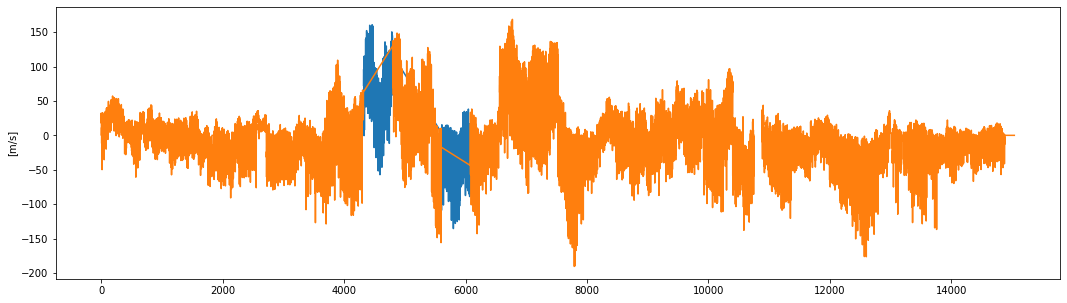

In [11]:
'''''''''
Split the data into test and train, and visualize.


Normally, I would select random forecasts to test on, which can easily be done.
However, in this case I want to make sure that the trained model can handle cases where the forecast 
vastly underestimates the measured current, and where it vastly overestimates the current
This does mean that less data in each case is used to train the mode, but this will improve as more data is collected.

'''''''''

# index for number of true errors
I=range(0,Y_data.shape[0])

# predefine arrays
X_data_test=np.empty((2,I_range,1+2*t_ex,32,2*range_pix,2*range_pix,4))
Y_data_test=np.empty((2,I_range,1+2*t_ex,32))

# split the test data into two cases (overestime and underestimates)
for k in range(2):
    X_data_test[k,:,:,:,:]=X_data[I_test[k,:],:,:,:,:]
    Y_data_test[k,:,:]=Y_data[I_test[k,:],:,:]

# for a last test, I want to test the model on ONLY the targeted lead time (not +/- the day chosen before)
X_data_final=X_data[I_test.flatten(),t_ex,:,:,:]
Y_data_final=Y_data[I_test.flatten(),t_ex,:]

I_train=range(n_f)
I_train=np.delete(I,I_test.flatten())

# populate arrays
X_data_train=X_data[I_train,:,:,:,:]
Y_data_train=Y_data[I_train,:,:]


X_data_test=X_data_test.reshape(2,np.array(X_data_test.shape[1:4]).prod(),2*range_pix,2*range_pix,4)
Y_data_test=Y_data_test.reshape(2,np.array(Y_data_test.shape[1:4]).prod(),1)

X_data_train=X_data_train.reshape(np.array(X_data_train.shape[:3]).prod(),2*range_pix,2*range_pix,4)
Y_data_train=Y_data_train.reshape(np.array(Y_data_train.shape[:3]).prod(),1)

# plot all the data and highlight the forecasts used for testing
plt.figure(figsize=(18,5))
plt.plot(Inx[I_test.flatten(),:,:].flatten(),Y_data_test.flatten())
plt.plot(Inx[I_train,:,:].flatten(),Y_data_train)
plt.ylabel('[m/s]')

In [14]:
# shuffle training data
p = np.random.permutation(X_data_train.shape[0])
X_data_train=X_data_train[p,:,:,:]
Y_data_train=Y_data_train[p,:,]
I = np.argwhere(~np.isnan(Y_data_train) & ~np.isinf(Y_data_train))[:,0]
X_data_train=X_data_train[I,:,:,:]
Y_data_train=Y_data_train[I,:]



In [39]:
# build tensorflow CNN model
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, regularizers
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(2*range_pix,2*range_pix, 4)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))


In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 8)         296       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 16)        1168      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 32)          4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)              

In [41]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [42]:
history = model.fit(X_data_train, Y_data_train, epochs=30,validation_split = 0.05,batch_size=50)
# Save the weights
model.save_weights(model_directory)

Train on 13193 samples, validate on 695 samples
Epoch 1/30
13193/13193 [==============================] - 23s 2ms/sample - loss: 1292.6559 - val_loss: 1065.5403
Epoch 2/30
13193/13193 [==============================] - 11s 829us/sample - loss: 1200.0447 - val_loss: 1084.8989
Epoch 3/30
13193/13193 [==============================] - 11s 858us/sample - loss: 1187.9760 - val_loss: 1043.2825
Epoch 4/30
13193/13193 [==============================] - 11s 821us/sample - loss: 1154.5540 - val_loss: 1073.8874
Epoch 5/30
13193/13193 [==============================] - 11s 827us/sample - loss: 1120.9538 - val_loss: 916.4179
Epoch 6/30
13193/13193 [==============================] - 12s 901us/sample - loss: 1050.5869 - val_loss: 879.2269
Epoch 7/30
13193/13193 [==============================] - 13s 987us/sample - loss: 900.2737 - val_loss: 704.8334
Epoch 8/30
13193/13193 [==============================] - 14s 1ms/sample - loss: 822.3123 - val_loss: 655.1094
Epoch 9/30
13193/13193 [==================

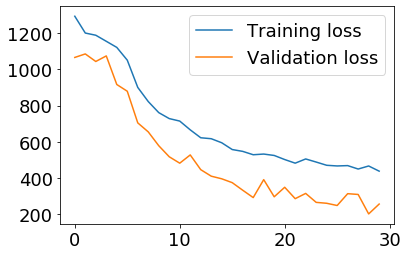

In [43]:
# plot losses
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Test period 1:
Mean model error raw: 87.1 +/- 39.8
Mean model error calibrated: 54.3 +/- 32.5
Test period 2:
Mean model error raw: -24.0 +/- 34.2
Mean model error calibrated: 1.7 +/- 16.0


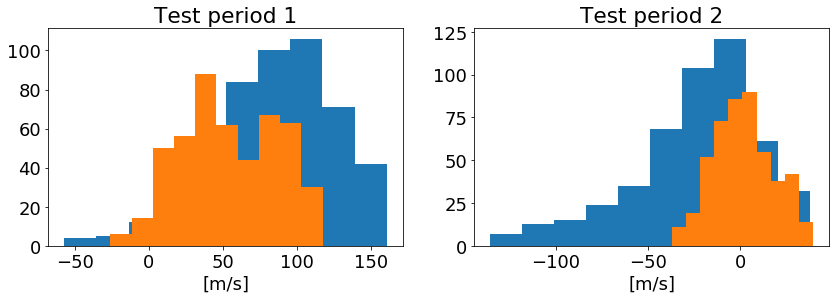

In [45]:
# Test model on unseen, un-shuffled data 
model.load_weights(model_directory)
fig, axs = plt.subplots(1,2, figsize=(14, 4), facecolor='w', edgecolor='k')
axs = axs.ravel()

for k in range(2):
    axs[k].hist(Y_data_test[k,:,:])
    P=model.predict(X_data_test[k,:,:,:,:])
    axs[k].hist(Y_data_test[k,:,:]-P)
    axs[k].title.set_text('Test period '+str(k+1))
    axs[k].set_xlabel('[m/s]')
    print('Test period '+str(k+1)+':')
    print('Mean model error raw: ' + str('%.1f' % np.nanmean(Y_data_test[k,:,:]))+ ' +/- '+str( '%.1f' %np.nanstd(Y_data_test[k,:,:])))
    print('Mean model error calibrated: ' + str( '%.1f' %np.nanmean(Y_data_test[k,:,:]-P))+ ' +/- '+str( '%.1f' %np.nanstd(Y_data_test[k,:,:]-P)))


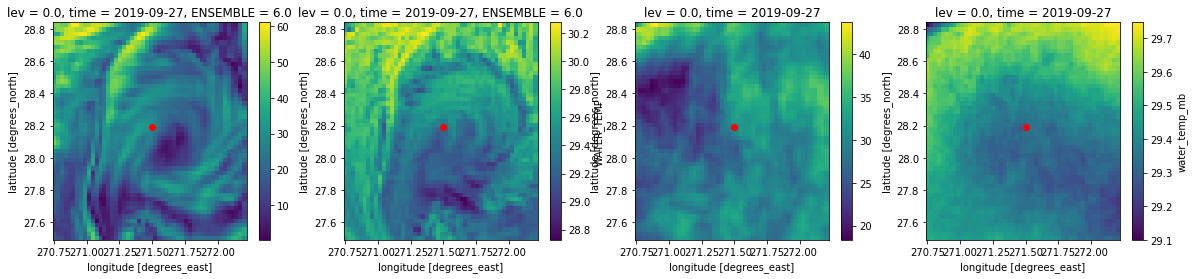

In [46]:
# plot some example images going into the CNN
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(20,4))
plt.subplot(141)
s[5,:,:].plot()
plt.plot(271.5,28.19,'ro')
plt.subplot(142)
t[5,:,:].plot()
plt.plot(271.5,28.19,'ro')
plt.subplot(143)
sm[:,:].plot()
plt.plot(271.5,28.19,'ro')
plt.subplot(144)
tm[:,:].plot()
plt.plot(271.5,28.19,'ro')
plt.savefig('./example_input.png')

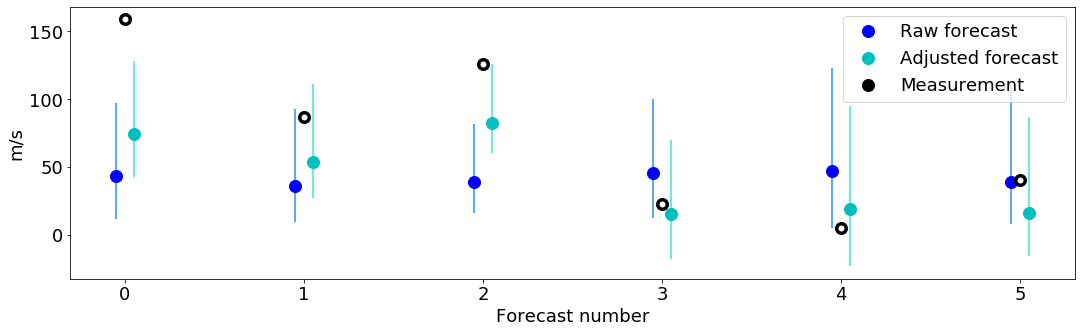

In [47]:
# finally, plot what predicted error from the CNN model would do to the unseen forecasts
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(18,5))
for k in range(X_data_final.shape[0]):
    p=X_data_final[k,:,range_pix,range_pix,0]
    pc=model.predict(X_data_final[k,:,:,:,:])
    meas=Y_data_final[k,:]+p
    plt.plot((k-0.05),np.mean(p),'bo', markersize=12, label='Raw forecast')
    
    plt.plot((k+0.05),np.mean(p+np.mean(pc)),'co', markersize=12, label='Adjusted forecast')
    p1=np.percentile(p,5)
    p2=np.percentile(p,95)
    err=np.empty((2,1))
    err[0,0]=abs(p1-np.mean(p))
    err[1,0]=p2-np.mean(p)
    plt.errorbar((k+0.05),np.mean(p+np.mean(pc)),yerr=err,ecolor='turquoise')
    plt.errorbar((k-0.05),np.mean(p),yerr=err,ecolor='dodgerblue')
    plt.plot(k,meas[0],'ko', markersize=12, label='Measurement')
    plt.plot(k,meas[0],'wo', markersize=5)
plt.xlabel('Forecast number')
plt.ylabel('m/s')
plt.legend(['Raw forecast', 'Adjusted forecast', 'Measurement'])
plt.savefig('./forecast_adj_test.png')